# Action detection, and classifications in videos

A video classification problem is not very different from an image classification problem. 
For an image classification task, we take images, use feature extractors, for example convolutional neural networks, to extract image features, and then the image is classified based on these extracted features. 
A simple way to deal with video classification, we need to extract the frames from the video and then we apply the same process as per image classification.

This notebook uses the [UCF101 – Action Recognition Data Set](https://www.crcv.ucf.edu/data/UCF101.php).

The dataset consists of 13,320 videos between ~2-10 seconds long of humans performing one of 101 possible actions. The dimensions of each frame are 320 by 240.

Another interesting dataset is [here](http://www.thumos.info/download.html)

## Imports

In [1]:
import os
import numpy as np
import cv2
import time
import h5py
import sys

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
#from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.distributed as dist
import torchvision  # used to download the model

from skimage import io, transform
import pathlib

from tqdm.notebook import tqdm

#from multiprocessing import Pool

In [2]:
print('cv2.__version__', cv2.__version__)
print('torch.__version__', torch.__version__)

cv2.__version__ 4.1.2
torch.__version__ 1.4.0


### Preparing the data

The following function uses a text file provided with the dataset
    which lists all of the relative paths for the videos for the train/test split. 
This function can be called with the location of the dataset 
(../data/UCF101/) and returns filenames and classes associated.

This notebook creates the following data folders:

~/number-five/data/UCF101$ 
.  
├── annotations  
├── compressed  
└── UCF-101  

In [3]:
base_directory = pathlib.Path('../data/UCF101/')
#base_directory.mkdir(parents=True, exist_ok=True)

save_dir = pathlib.Path('../saved-mdls/09-action-detection-in-videos/')
save_dir.mkdir(parents=True, exist_ok=True)

In [4]:
def getUCF101(base_directory = '', remove_classname = False, train=True):
    """
    This function uses a text file provided with the dataset
    which lists all of the relative paths for the videos for the train/test split. 
    This function can be called with the location of the dataset 
    (../data/UCF101/) and returns three variables:
    - class_list is a list of the action categories. 
    - train is a tuple. 
      The first element is a numpy array with the absolute 
      filepaths for the videos for training. 
      The second element is a numpy array of class indices (0-100). 
    - test is a tuple in the same format as train but for the test dataset.
    """

    print(f'[getUCF101] Reading data from: {base_directory}')
    
    # action class labels
    class_file = open(base_directory/'annotations/ucfTrainTestlist/classInd.txt','r')
    lines = class_file.readlines()
    lines = [line.split(' ')[1].strip() for line in lines]
    class_file.close()
    class_list = np.asarray(lines)

    if train:
        # training data
        train_file = open(base_directory/'annotations/ucfTrainTestlist/trainlist01.txt','r')
        lines = train_file.readlines()      
        if remove_classname:
            filenames = ['/UCF-101/' + line.split(' ')[0].split('/')[1] for line in lines]
        else:
            filenames = ['/UCF-101/' + line.split(' ')[0] for line in lines]
        y_train = [int(line.split(' ')[1].strip())-1 for line in lines]
        y_train = np.asarray(y_train)    
        filenames = [base_directory.as_posix() + filename for filename in filenames]
        train_file.close()
        train = (np.asarray(filenames),y_train)
        
        file_list = train
        
    else:
        # testing data
        test_file = open(base_directory/'annotations/ucfTrainTestlist/testlist01.txt','r')
        lines = test_file.readlines()
        filenames = ['/UCF-101/' + line.split(' ')[0].strip() for line in lines]
        classnames = [filename.split('/')[2] for filename in filenames]

        if remove_classname:
            # remove the class name from the filename if needed.
            filenames = ['/UCF-101/' + line.split(' ')[0].split('/')[1].strip() for line in lines]

        y_test = [np.where(classname == class_list)[0][0] for classname in classnames]
        y_test = np.asarray(y_test)
        filenames = [base_directory.as_posix() + filename for filename in filenames]
        test_file.close()
        test = (np.asarray(filenames),y_test)
        
        file_list = test

    print('[getUCF101] Done.')
    return class_list, file_list

In [5]:
def download_ucf101(target_dir='../data/UCF101/'):
    print('1/2 Beginning file download...')

    compressed_dir = pathlib.Path(target_dir + '/compressed')
    compressed_dir.mkdir(parents=True, exist_ok=True)

    annotations_dir = pathlib.Path(target_dir + '/annotations')
    annotations_dir.mkdir(parents=True, exist_ok=True)
    
    destination_dir = pathlib.Path(target_dir + '/UCF-101')
    destination_dir.mkdir(parents=True, exist_ok=True)

    # download annotations for action recognition
    if pathlib.Path(compressed_dir/'UCF101TrainTestSplits-RecognitionTask.zip').exists():
        print ("File UCF101TrainTestSplits-RecognitionTask.zip exists.")
    else:    
        annotation_url = 'https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip'
        filename = wget.download(annotation_url, out=compressed_dir.as_posix(), bar=wget.bar_adaptive)
        print(f'File downloaded to {filename}')
        
    if pathlib.Path(compressed_dir/'UCF101TrainTestSplits-DetectionTask.zip').exists():
        print ("File UCF101TrainTestSplits-DetectionTask.zip exists.")
    else:        
        # download annotations for action detection
        annotation_url = 'https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-DetectionTask.zip'
        filename =wget.download(annotation_url, out=compressed_dir.as_posix(), bar=wget.bar_adaptive)
        print(f'File downloaded to {filename}')
        
    # download videos
    if pathlib.Path(compressed_dir/'UCF101.rar').exists():
        print ("File UCF101.rar exists.")
    else:            
        video_url = 'https://www.crcv.ucf.edu/data/UCF101/UCF101.rar'
        filename =wget.download(video_url, out=compressed_dir.as_posix(), bar=wget.bar_adaptive)
        print(f'File downloaded to {filename}')
        
    print('1/1 Completed.\n')

In [6]:
# download_ucf101()

In [7]:
def extract_ucf101(target_dir='../data/UCF101/'):
    print('2/2 Extracting data...')

    target_dir = pathlib.Path(target_dir)
    
    compressed_dir = pathlib.Path(target_dir/'compressed')
    compressed_dir.mkdir(parents=True, exist_ok=True)

    annotations_dir = pathlib.Path(target_dir/'annotations')
    annotations_dir.mkdir(parents=True, exist_ok=True)
    
    destination_dir = pathlib.Path(target_dir/'UCF-101')
    destination_dir.mkdir(parents=True, exist_ok=True)   

    try:
        bash_cmd = 'unrar ' + target_dir.as_posix() + '/UCF101.rar' + ' ' + target_dir.as_posix() + '/UCF-101'
        print(bash_cmd)
        process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
        print(output)
    except Exception as e:
        print(e)
        
    print()
    #
    # need unrar to use it (apt-get install unrar-free)        

    bash_cmd = 'cp ' + target_dir.as_posix() + '/compressed/UCF101TrainTestSplits-RecognitionTask.zip ' + annotations_dir.as_posix() + '/UCF101TrainTestSplits-RecognitionTask.zip'
    print(bash_cmd)
    process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    if len(output) > 0: print(output)
    if len(error) > 0: print(error)
    
    print()
    
    bash_cmd = 'unzip ' + annotations_dir .as_posix() + '/UCF101TrainTestSplits-RecognitionTask.zip -d ' + annotations_dir.as_posix()
    print(bash_cmd)
    process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    if len(output) > 0: print(output)
    if len(error) > 0: print(error)
        
    print()    
    
    bash_cmd = 'cp ' + target_dir.as_posix() + '/compressed/UCF101TrainTestSplits-DetectionTask.zip ' + annotations_dir.as_posix() + '/UCF101TrainTestSplits-DetectionTask.zip'
    print(bash_cmd)
    process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    if len(output) > 0: print(output)
    if len(error) > 0: print(error)
        
    print()
    
    
    bash_cmd = 'unzip ' + annotations_dir.as_posix() + '/UCF101TrainTestSplits-DetectionTask.zip -d ' + annotations_dir.as_posix()
    print(bash_cmd)    
    process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    if len(output) > 0: print(output)
    if len(error) > 0: print(error)
        
    print()
    
        
    bash_cmd = 'rm ' + target_dir.as_posix() + '/annotations/*.zip'
    print(bash_cmd)    
    process = subprocess.Popen(bash_cmd.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    if len(output) > 0: print(output)
    if len(error) > 0: print(error)
        
    print()
    
    
    print('2/2 Completed.')

In [8]:
# extract_ucf101()

In [9]:
class_list, train = getUCF101(base_directory, train=True)

[getUCF101] Reading data from: ../data/UCF101
[getUCF101] Done.


### Load frame

The following function is used for loading a single frame from a particular video in the dataset. 

args is a tuple with the first argument being the location of a video (which is in train[0] and test[0] from the getUCF101() function) 
and the second argument specifies whether data augmentation should be performed. 

The video paths in train and test look something like this: `../data/UCF101/UCF101-videos/FloorGymnastics/v_FloorGymnastics_g23_c01.avi.`

A random frame is selected and if augment==True, the frame is randomly cropped, resized to the appropriate dimension for the model, flipped, and has its brightness adjusted. 

The frame is normalized based on the provided mean and std for the default PyTorch pretrained ResNet-50 model. 

Finally the data is returned and is a numpy array of size [3,224,224] of type np.float32. 


Note: The original dataset (which can be downloaded [here](https://www.crcv.ucf.edu/data/UCF101.php)) is relatively small (9.5GB). 
However, it can be extremely slow to load and decode video files from memory. 
Because of this, sometime (e.g. [here](https://courses.engr.illinois.edu/ie534/fa2019/AR.html)) video files are stored as numpy arrays of size [sequence_length,height,width,3].
This makes them very quick to load but extremely large (~500GB). 
In this case, the dataset is stored as hdf5 files.
This function can also convert the avi paths to hdf5.

In [10]:
def loadFrame(filename, filetype='avi', frame_index=None):
    """
    
    ref. VideoCapture properties: 
         https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get
    """

    try:        
        if filetype == 'hdf5':
            ### load file from HDF5
            filename = filename.replace('.avi','.hdf5')
            filename = filename.replace('UCF101','UCF101-hdf5')
            h = h5py.File(filename,'r')
            nFrames = len(h['video']) - 1
            frame_index = np.random.randint(nFrames)
            frame = h['video'][frame_index]
        else:
            ### load file from AVI
            cap = cv2.VideoCapture(filename.as_posix())   

            if not cap.isOpened(): 
                print(f"could not open {filename}") 
                frame = np.array([])
                return frame

            nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            #frameWidth   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            #frameHeight  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps     = cap.get(cv2.CAP_PROP_FPS)
    
#             if frame_index is not None:
#                 print('WARNING: using user selected frame index.')
                
    
            frame = None
            while frame is None:
                if frame_index is None:
                    frame_index = np.random.randint(nFrames)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
                ret, frame = cap.read()  
                if frame is None:
                    print(f'ERROR in file: {filename}, frame_index: {frame_index}. Retrying with different random frame number.')
                    frame_index = None

            cap.release()
         
        frame = frame.astype(np.float32)
        
    except ValueError as e:
        print(f"Exception: {filename} \n", e)
    except Exception as e:
        print("Exception: " + filename.as_posix())
        print("   Details: ", e)
        print("loadFrame variables: ")
        print("   - nFrames: ", nFrames)
        print("   -     fps: ", fps)
        print("   - frame_index: ", frame_index)        
        
        #print("Unexpected error:", sys.exc_info()[0])    
        frame = np.array([])
                
    return frame

Test the loadFrame function:

In [11]:
video_filename = base_directory/'UCF-101/YoYo/v_YoYo_g25_c05.avi'
frame = loadFrame(video_filename, filetype='avi', frame_index=15)

In [12]:
def frameToImg(frame):
    # swap columns to be shown as image
    # frame = np.moveaxis(frame, 0, -1) # data = np.moveaxis(data, source, destination) 
    
    if type(frame) == torch.Tensor:
        frame = frame.data.numpy()
        frame = frame.transpose(1, 2, 0)
        
    n_frame = (frame-np.min(frame))/np.max(frame-np.min(frame))    
    return n_frame

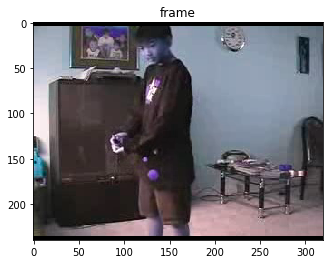

In [13]:
%matplotlib inline 

plt.imshow(frameToImg(frame))
plt.title('frame');

### Load a frame sequence

The following function is very similar to the loadFrame() function. 
The 3D ResNet-50 model is trained on sequences of length 16. 
This function simply grabs a random subsequence of frames and augments them all in the exact same way (this is important when performing data augmentation on videos). 
This function returns a numpy array of size [3,16,224,224]. 
The last three channels must be the time and space dimensions since the PyTorch 3D convolution implementation acts on the last three channels of an input with size [batch_size,num_of_input_features,time,height,width].

In [14]:
def loadSequence(filename, num_of_frames=16, augment=True, filetype='avi'):
    mean = np.asarray([0.433, 0.4045, 0.3776],np.float32)
    std = np.asarray([0.1519876, 0.14855877, 0.156976],np.float32)

    curr_w = 320
    curr_h = 240
    height = width = 224
    
    data = np.zeros((3,num_of_frames,height,width),dtype=np.float32)

    try:
        if filetype == 'hdf5':
            ### load file from HDF5
            filename = filename.replace('.avi','.hdf5')
            filename = filename.replace('UCF-101','UCF-101-hdf5')
            h = h5py.File(filename,'r')
            nFrames = len(h['video']) - 1
            frame_index = np.random.randint(nFrames - num_of_frames)
            video = h['video'][frame_index:(frame_index + num_of_frames)]
        else:
            ### load file from AVI
            cap = cv2.VideoCapture(filename)   

            if not cap.isOpened(): 
                print(f"could not open {filename}") 
                return

            nFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            #frameWidth   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            #frameHeight  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps     = cap.get(cv2.CAP_PROP_FPS)

            frame_index = np.random.randint(nFrames - num_of_frames)
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

            video = []        
            f_count = 0
            while cap.isOpened() and f_count < num_of_frames:
                frameId = cap.get(cv2.CAP_PROP_POS_FRAMES) # current frame number
                ret, frame = cap.read() 
                video.append(frame)
                f_count += 1
                
            cap.release()
            
        if(augment==True):
            ## RANDOM CROP - crop 70-100% of original size
            ## don't maintain aspect ratio
            resize_factor_w = 0.3*np.random.rand()+0.7
            resize_factor_h = 0.3*np.random.rand()+0.7
            w1 = int(curr_w*resize_factor_w)
            h1 = int(curr_h*resize_factor_h)
            w = np.random.randint(curr_w-w1)
            h = np.random.randint(curr_h-h1)
            random_crop = np.random.randint(2)

            ## Random Flip
            random_flip = np.random.randint(2)

            ## Brightness +/- 15
            brightness = 30
            random_add = np.random.randint(brightness+1) - brightness/2.0

            data = []
            for frame in video:
                if(random_crop):
                    frame = frame[h:(h+h1),w:(w+w1),:]
                if(random_flip):
                    frame = cv2.flip(frame,1)
                frame = cv2.resize(frame,(width,height))
                frame = frame.astype(np.float32)
                
                frame += random_add
                frame[frame>255] = 255.0
                frame[frame<0] = 0.0

                frame = frame/255.0
                frame = (frame - mean)/std
                data.append(frame)
            data = np.asarray(data)

        else:
            # don't augment
            data = []
            for frame in video:
                frame = cv2.resize(frame,(width,height))
                frame = frame.astype(np.float32)
                frame = frame/255.0
                frame = (frame - mean)/std
                data.append(frame)
            data = np.asarray(data)

        data = data.transpose(3,0,1,2)
    except:
        print("Exception: " + filename)
        data = np.array([])
    return data

Test the loadSequence function:

In [15]:
data = loadSequence('../data/UCF101/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi', 
                    num_of_frames=16,
                    augment=True, 
                    filetype='avi')

In [16]:
data.shape

(3, 16, 224, 224)

In [17]:
# swap columns to be shown as image
data = np.moveaxis(data, 0, -1)

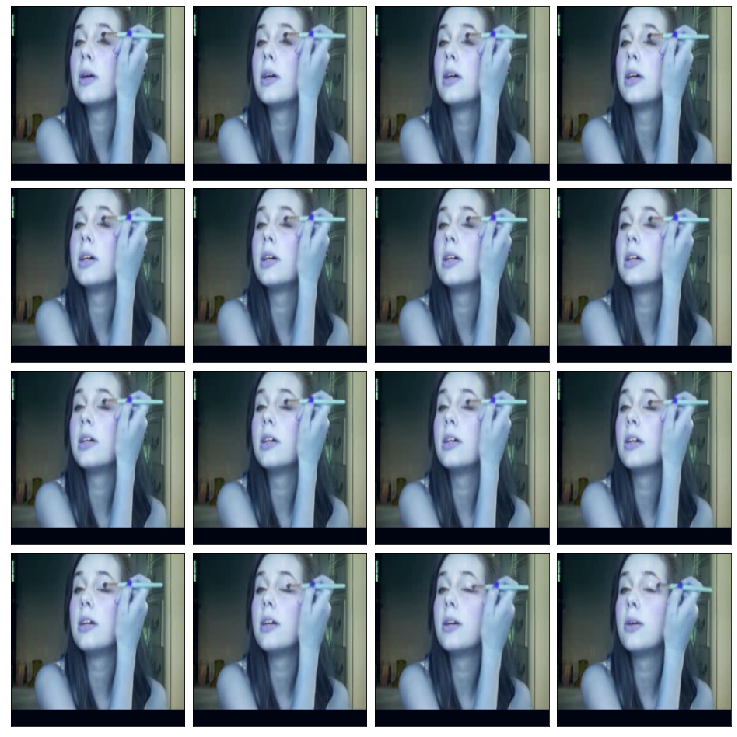

In [18]:
%matplotlib inline 

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

n_frames = data.shape[0]

max_frames = 16 # max number of frames to plot
for idx, frame in enumerate(data):  
    if idx < max_frames:
        plt.subplot(4, 4, idx+1, xticks=[], yticks=[])
        normalised_frame = (frame-np.min(frame))/np.max(frame-np.min(frame))
        plt.imshow( normalised_frame )
    else:
        break
    

### Using pytorch Dataset and DataLoaders

In [19]:
class SingleFrameDataset(Dataset):
    """Single frame dataset."""

#    def __init__(self, video_list, root_dir, transform=None):
    def __init__(self, root_dir, train=True, transform=None):
        """
        Args:            
            root_dir (string): Directory with all the videos.
            train: flag to say whether train or test dataset is used.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = pathlib.Path(root_dir)
        self.class_list, self.file_list = getUCF101(base_directory=self.root_dir, train=train)

        self.transform = transform

    def __len__(self):
        return len(self.file_list[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        video_list = self.file_list[0][idx]
        frame = loadFrame(pathlib.Path(video_list), filetype='avi')
                                    
        label = self.file_list[1][idx]
        label = np.array([label])
#        label = label.astype('float').reshape(-1, 2)
        sample = {'image': frame, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)

        return sample
            

## Creating transformations

In [20]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']        
        
#         # load frame has images as (channels x height x width).
#         # we need to transpose them.
#         #image = image.transpose(1, 2, 0)  # swap columns
        
#         # for images, x and y axes are axis 1 and 0 respectively
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        # for some reason the cv2.resize call fails when used in a DataLoader
            
#        img = img.transpose(2, 0, 1)   # swap columns to get back to the original dimensions

        return {'image': img, 'label': label}

In [21]:
class RandomCropOld(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        
        image, label = sample['image'], sample['label']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
            
        if h - new_h > 0:                
            top = np.random.randint(0, h - new_h)            
        else:
            top = 0

        if w - new_w > 0:
            left = np.random.randint(0, w - new_w)
        else:
            left = 0

        # crop
        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'label': label}

In [22]:
class RandomCrop(object):
    """Crop randomly the image in a sample.
    NOTE: Output does not keep the same aspect ratio.
    
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.            
    """

    def __init__(self, out_ratio=0.7, p_crop=0.5):
        self.out_ratio = out_ratio
        self.p_crop = p_crop
        
    def __call__(self, sample):        
        image, label = sample['image'], sample['label']

        curr_h, curr_w = image.shape[:2]
        
        resize_factor_w = (1-self.out_ratio)*np.random.rand()+self.out_ratio
        resize_factor_h = (1-self.out_ratio)*np.random.rand()+self.out_ratio
        w1 = int(curr_w*resize_factor_w)
        h1 = int(curr_h*resize_factor_h)
        w = np.random.randint(curr_w-w1)
        h = np.random.randint(curr_h-h1)
                
        # crop
        if np.random.uniform() <= self.p_crop:
            image = image[h:(h+h1),w:(w+w1),:]

        return {'image': image, 'label': label}

In [23]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if type(label) != np.ndarray:
            label = np.ndarray(label)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [24]:
class Normalize(object):
    """Normalises an image.
        
    Args:
        mean and std values. Deafult values based on the default pytorch 
        pretrained ResNet-50 model.      
        
        old values: 
        - mean: np.asarray([0.485, 0.456, 0.406]
        - std : np.asarray([0.229, 0.224, 0.225]
    """

    def __init__(self, mean = np.asarray([0.433, 0.4045, 0.3776], np.float32),
                       std  = np.asarray([0.1519876, 0.14855877, 0.156976], np.float32)):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        ## resnet model was trained on images with mean subtracted
        image = image/255.0
        
        return {'image': (image - self.mean)/self.std,
                'label': label}

In [25]:
class RandomHorizontalFlip(object):
    """Randomly horizontally flip the image in a sample.  
    
    Args: prob of flipping the sample
    """
    def __init__(self, p_flip = .5):
        self.p = p_flip

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if np.random.uniform() <= self.p:
            image = cv2.flip(image, 1)  # one is horizontally                   
        
        return {'image': image, 'label': label}
    

In [26]:
class AddRandomBrightness(object):
    """Randomly add brightness between a minimum and maximum value.
    Saturates if needed. """
    
    def __init__(self, b_offset = 15):
        self.brightness = b_offset*2  # brightness +/- b_offset
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        image += np.random.randint(self.brightness+1) - self.brightness/2.0
        
        #saturates:
        image[image>255] = 255.0
        image[image<0]   = 0.0
        
        return {'image': image, 'label': label}

We add one more helper funtion to show images

In [27]:
def show_image(image, label=None, normalize=True):
    """Show image with label"""
    
    if type(image) == torch.Tensor:
        image = image.data.numpy()
        image = image.transpose(1, 2, 0)
        
    if normalize:        
        image = (image-np.min(image))/np.max(image-np.min(image))    
    
    plt.imshow(image)
    if label: plt.title(label)    

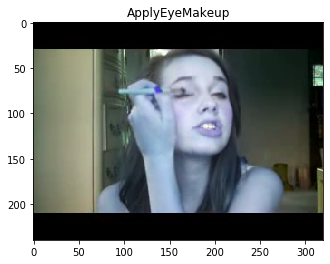

In [28]:
%matplotlib inline
frame = loadFrame(base_directory/'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi', filetype='avi')
show_image(frame, 'ApplyEyeMakeup', normalize=True)

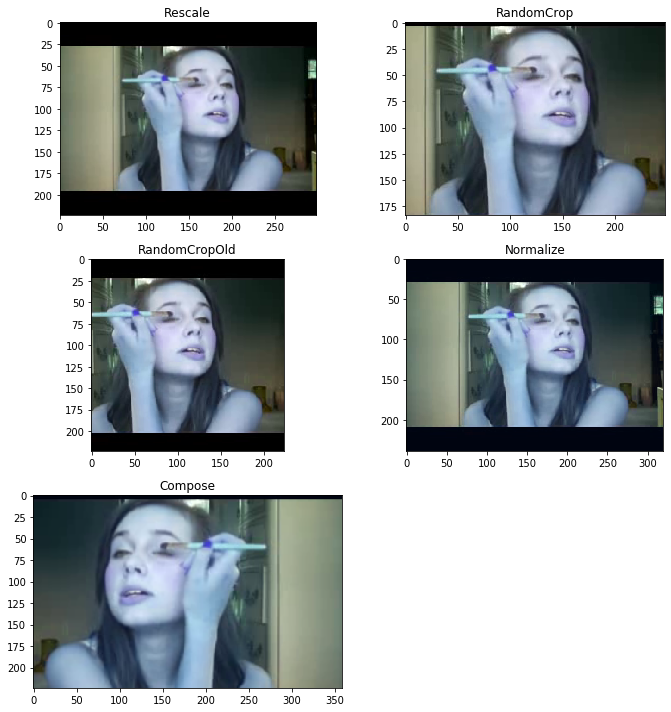

In [29]:
%matplotlib inline


scale = Rescale(224)
crop = RandomCrop(p_crop=1.0)
cropOld = RandomCropOld(224)
normalize = Normalize()

composed = transforms.Compose([RandomCrop(out_ratio=0.7, p_crop=1.0),
                               RandomHorizontalFlip(1.),
                               Rescale(224),
                               AddRandomBrightness(),                               
                               Normalize()])

tsmf_list = [scale, crop, cropOld, normalize, composed]

# Apply each of the above transforms on sample.
sample = {'image': loadFrame(base_directory/'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi', filetype='avi'), 
          'label': 0}

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i, tsfrm in enumerate(tsmf_list):
    transformed_sample = tsfrm(sample)
    
    ax = plt.subplot(np.ceil(len(tsmf_list)/2), 2, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)

    # to check that Normalize() is working, call the function below with normalize=False
    show_image(transformed_sample['image'], normalize=True)


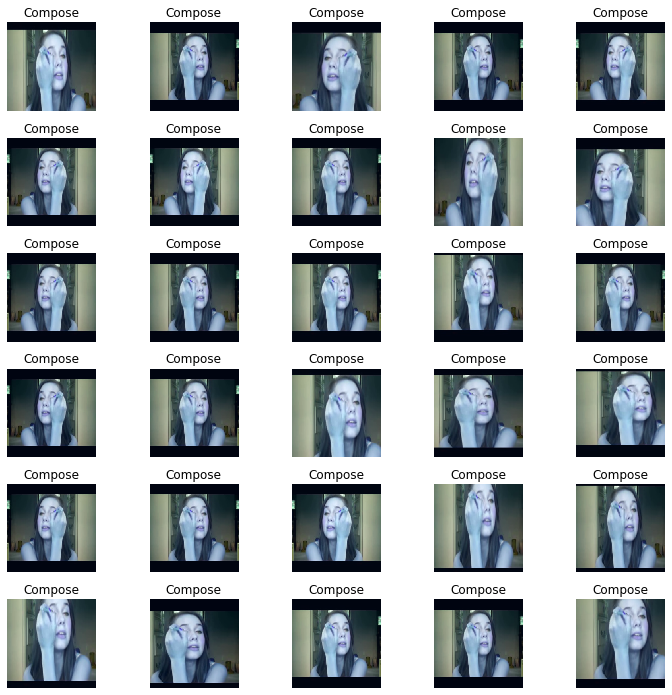

In [30]:
composed = transforms.Compose([RandomCrop(out_ratio=0.7, p_crop=0.5),
                               RandomHorizontalFlip(0.5),
                               Rescale((224,224)),
                               AddRandomBrightness(),                               
                               Normalize(),
                               ToTensor()])

# Apply each of the above transforms on sample.
sample = {'image': loadFrame(base_directory/'UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi', filetype='avi'), 
          'label': 0}

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0, right=0.1, bottom=0, top=0.1, hspace=0.0, wspace=0.0)

n_plots = 30
n_columns = 5
for i in range(n_plots):
    transformed_sample = composed(sample)
    
    ax = plt.subplot(np.ceil(n_plots/n_columns), n_columns, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.axis('off')

    # to check that Normalize() is working, call the function below with normalize=False
    show_image(transformed_sample['image'], normalize=True)

In [31]:
# tsfms = transforms.Compose([Rescale(224),
#                             RandomCrop(224),
#                             RandomHorizontalFlip(.5),
#                             Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                             ToTensor()])


tsfms = transforms.Compose([RandomCrop(out_ratio=0.7, p_crop=0.5),
                            RandomHorizontalFlip(0.5),
                            Rescale((224,224)),
                            AddRandomBrightness(),                               
                            Normalize(),
                            ToTensor()])

In [32]:
train_ds = SingleFrameDataset(base_directory, transform=tsfms)
class_names = train_ds.class_list

[getUCF101] Reading data from: ../data/UCF101
[getUCF101] Done.


In [33]:
def sampleToImg(sample):
    # swap columns to be shown as image
    frame = sample['image']
    
    if type(frame) == torch.Tensor:
        frame = frame.data.numpy()
        frame = frame.transpose(1, 2, 0)
        
    n_frame = (frame-np.min(frame))/np.max(frame-np.min(frame))
    return n_frame

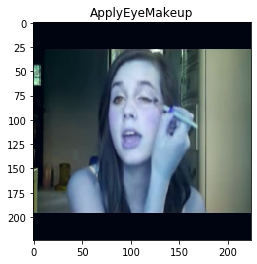

In [34]:
%matplotlib inline 

f_id = 1

plt.imshow(frameToImg(train_ds[f_id]['image']))
plt.title(train_ds.class_list[train_ds[f_id]['label']]);


`torch.utils.data.DataLoader` is an iterator which provides:

- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.

this avoid losing a lot of features by using a simple for loop to iterate over the data.


One parameter of interest is `collate_fn`. You can specify how exactly the samples need to be batched using `collate_fn`. However, default collate should work fine for most use cases.

In [35]:
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)

In [36]:
# Helper function to show a batch
def showBatch(sample_batched):
    """Show image for a batch of samples. Must be tensors of size (bs x channels x h x w)"""
    images_batch = sample_batched['image']
    labels_batch = sample_batched['label']
    
    batch_size = len(images_batch)
    im_size = images_batch.size()

    grid_border_size = 2

    grid = utils.make_grid(images_batch, nrow=1)
    
    ncols = int(np.ceil(np.sqrt(batch_size)))
    
    for i in range(batch_size):
        ax = plt.subplot(ncols, ncols, i + 1)
        plt.tight_layout()
        ax.axis('off')
        if type(images_batch[i]) == torch.Tensor:
            frame = images_batch[i].data.numpy()
            frame = frame.transpose(1, 2, 0)
            plt.imshow(np.clip(frame, 0, 1))
        else:
            plt.imshow(np.clip(images_batch[i], 0, 1))
    
    #plt.imshow(np.clip(grid.numpy().transpose((1, 2, 0)), 0,1))

    title_str = 'Classes: '
    for i in range(batch_size):
         title_str += train_ds.class_list[labels_batch[i][0].numpy()] + '(' + str(labels_batch[i][0].numpy()) + '); '
    #plt.title(title_str)
    print(title_str)

0 torch.Size([4, 3, 224, 224])
1 torch.Size([4, 3, 224, 224])
2 torch.Size([4, 3, 224, 224])
3 torch.Size([4, 3, 224, 224])
Classes: PlayingDhol(60); BandMarching(5); MilitaryParade(52); JumpingJack(46); 


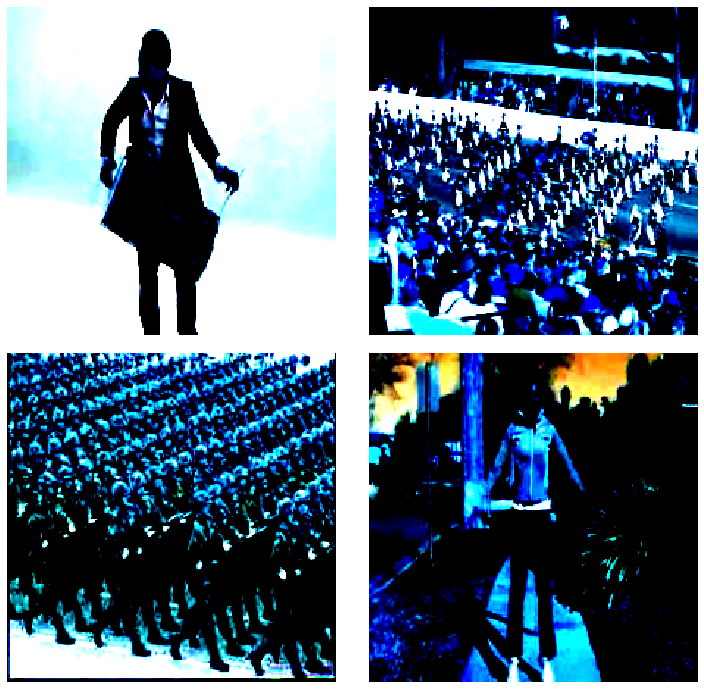

In [37]:
for i_batch, sample_batched in enumerate(train_dl):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure(figsize=(10,10))
        showBatch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [38]:
train_ds.class_list[65]

'PlayingTabla'

## Single frame model

This model uses a pretrained ResNet-50 model pretrained on ImageNet and bases the classification on feeding the network one frame at a time.

Although the dataset has a large number of frames (13000 videos * number of frames per video), the frames are correlated with eachother meaning there isn’t a whole lot of variety. Also, to keep the sequences relatively short (~2-10 seconds), some of the original videos were split up into 5-6 shorter videos meaning there is even less variety. 

Single frames alone can still provide a significant amount of information about the action being performed (consider the classes “Skiing” versus “Baseball Pitch”). Training a CNN from scratch significantly overfits. However, the features from a CNN pretrained on ImageNet (over 1 million images of 1000 classes) can be very useful even in video based problem like action recognition. A single frame model performs surprisingly well. This doesn’t necessarily mean solving the task of learning from images inherently solves all video related tasks. It’s more likely that with the problem of human action recognition, the spatial information is more important than the temporal information.

In [39]:
IMAGE_SIZE = 224
NUM_CLASSES = 101
batch_size = 64
lr = 0.0001
num_of_epochs = 10

### Load the data using Datasets and DataLoaders

In [40]:
data_directory = pathlib.Path('../data/UCF101/')

class_list, train = getUCF101(base_directory = data_directory, train=True)

class_list_test, test = getUCF101(base_directory = data_directory, train=False)

[getUCF101] Reading data from: ../data/UCF101
[getUCF101] Done.
[getUCF101] Reading data from: ../data/UCF101
[getUCF101] Done.


In [41]:
train_ds_size = len(train[0])
dataset_size = train_ds_size

print(f'Train Dataset size: {dataset_size}')

Train Dataset size: 9537


In [42]:
test_ds_size = len(test[0])
print(f'Test Dataset size: {test_ds_size}')

Test Dataset size: 3783


In [43]:
### Train Dataset and DataLoader

In [74]:
train_tsfms = transforms.Compose([RandomCrop(out_ratio=0.7, p_crop=0.5),
                            RandomHorizontalFlip(p_flip=0.5),
                            Rescale((IMAGE_SIZE,IMAGE_SIZE)),
                            AddRandomBrightness(),                               
                            Normalize(),
                            ToTensor()])


train_ds = SingleFrameDataset('../data/UCF101/', transform=train_tsfms)
class_names = train_ds.class_list

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

[getUCF101] Reading data from: ../data/UCF101
[getUCF101] Done.


In [45]:
### Test Dataset and DataLoader

In [75]:
test_tsfms = transforms.Compose([Rescale((IMAGE_SIZE,IMAGE_SIZE)),
                                 Normalize(),
                                 ToTensor()])

test_ds = SingleFrameDataset('../data/UCF101/', train=False, transform=test_tsfms)
class_names = test_ds.class_list

test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

[getUCF101] Reading data from: ../data/UCF101
[getUCF101] Done.


### Load the model from torchvision.

Here is the link to the torch zoo of network models. It is worth taking a look at this page: [models](https://pytorch.org/docs/stable/torchvision/models.html).

Results are saved in: ~/.cache/torch/checkpoints/resnet50-19c8e357.pth

In [76]:
model = torchvision.models.resnet50(pretrained=True)

Replace the last fully connected layer to match the number of classes that we need. 

To do so we can use the name of the last layer (fc) and replace it with what we need.
To check the name we can simply run `model` in a cell.

In [77]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [78]:
# Replace the last fully-connected layer
# Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(2048, NUM_CLASSES) 

Freeze the parameters of the parts we do not want to train and set to true those of the last few layers that we are interested in updating.

The dataset is not large enough to warrant training a full ResNet-50 model. 

To start, we will just fine-tune the output layer and the last BottleNeck block (or residual block). `model.layer4` contains three residual blocks implying model.layer4[2] is the last of these three residual blocks. Fine-tuning only the top layers also reduces the amount of GPU memory, meaning a higher batch size can be used and the model can be trained more quickly with less overfitting.

In [79]:
for param in model.parameters():
    param.requires_grad_(False)

In [80]:
for param in model.layer4[2].parameters():
    param.requires_grad_(True)
for param in model.fc.parameters():
    param.requires_grad_(True)

In [81]:
params = []
# for param in model.conv1.parameters():
#     params.append(param)
# for param in model.bn1.parameters():
#     params.append(param)
# for param in model.layer1.parameters():
#     params.append(param)
# for param in model.layer2.parameters():
#     params.append(param)
# for param in model.layer3.parameters():
#     params.append(param)
for param in model.layer4[2].parameters():
    params.append(param)
for param in model.fc.parameters():
    params.append(param)

    

In [82]:
optimizer = optim.Adam(params, lr=lr)
criterion = nn.CrossEntropyLoss()

### Training

In [83]:
# # Get a batch of training data
# inputs = next(iter(train_dl))

In [84]:
if torch.cuda.is_available():
    model.cuda()

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [96]:
data_dl = {"train": train_dl} #, "test": test_dl}

In [97]:
def train_model(model, criterion, optimizer, num_epochs=num_of_epochs):
    since = time.time()

    for epoch in range(0, num_epochs):        
        
        for phase in data_dl.keys():
        
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            _train_accu = []
            running_datasize = 0
            running_loss = 0.0
            running_corrects = 0        
        
            # iterate over data according to each phase (train or validation)
            for batch in tqdm(data_dl[phase], ascii=True, desc='Epoch {}/{} Phase {}: '.format(epoch+1, num_epochs, phase)):
                inputs = batch['image']
                labels = batch['label']
                
                batch_size = len(labels)

                inputs = inputs.to(device).contiguous()
                labels = labels.to(device)

                labels = labels.squeeze()
                if len(labels.size()) == 0:
                    labels = torch.tensor([labels]).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #  assert outputs.size(0) == labels.size(0)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics   
                running_datasize += len(inputs)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                _acc = ( float( preds.eq(labels.data).sum() ) /float(batch_size))*100.0

                epoch_loss = running_loss / dataset_size
                epoch_acc = running_corrects.double() / dataset_size

                _train_accu.append(_acc)
                        
        print('Epoch: {:.0f} {}: Loss: {:.4f} Acc: {:.4f} DataSize: {:.0f}'.format(epoch, phase, epoch_loss, epoch_acc, running_datasize))            

        epoch_acc = np.mean(_train_accu)
        #print(epoch, accuracy_epoch,time.time()-start_time)
        
        torch.save(model, save_dir/'single-frame-model.pt')

    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('-' * 10)
    print(f'Latest model saved in: {save_dir}/single-frame-model.pt')
        
    print(f'dataset size: {dataset_size}')
    return model



In [98]:
model = train_model(model, criterion, optimizer, num_epochs=10)


Epoch: 0 train: Loss: 0.1633 Acc: 0.9697 DataSize: 9537



Epoch: 1 train: Loss: 0.1353 Acc: 0.9761 DataSize: 9537


ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g12_c01.avi, frame_index: 277. Retrying with different random frame number.

Epoch: 2 train: Loss: 0.1286 Acc: 0.9763 DataSize: 9537



Epoch: 3 train: Loss: 0.1156 Acc: 0.9772 DataSize: 9537



Epoch: 4 train: Loss: 0.1032 Acc: 0.9789 DataSize: 9537


ERROR in file: ../data/UCF101/UCF-101/Basketball/v_Basketball_g16_c01.avi, frame_index: 527. Retrying with different random frame number.

Epoch: 5 train: Loss: 0.0902 Acc: 0.9832 DataSize: 9537


ERROR in file: ../data/UCF101/UCF-101/Diving/v_Diving_g22_c06.avi, frame_index: 180. Retrying with different random frame number.

Epoch: 6 train: Loss: 0.0822 Acc: 0.9843 DataSize: 9537



Epoch: 7 train: Loss: 0.0756 Acc: 0.9872 DataSize: 9537



Epoch: 8 train: Loss: 0.0658 Acc: 0.9879 DataSize: 9537


ERROR in file: ../data/UCF101/UCF-101/TennisSwing/v_TennisSwing_g24_c04.avi, frame_index: 95. Retrying with different random frame number.

Epoch: 9 train: Loss: 0.0731 Acc: 0.9846 DataSize: 9537

Training complete in 11m 8s
----------
Latest model saved in: ../saved-mdls/09-action-detection-in-videos/single-frame-model.pt
dataset size: 9537


### Saving the final model

In [ ]:
torch.save(model, save_dir/'09-single-frame-model.pt')

## Testing

Note that the rest of the notebook only considers a single frame. At true test time, it would make sense to average out the prediction over every frame within a video.

Before testing though, let's prepare the directory structure that should make our life easier.

In [ ]:
##### save predictions directory
prediction_directory = 'UCF-101-predictions/'
if not os.path.exists(prediction_directory):
    os.makedirs(prediction_directory)
for label in test.class_list:
    if not os.path.exists(prediction_directory+label+'/'):
        os.makedirs(prediction_directory+label+'/')

In [120]:
model = torch.load(save_dir/'09-single-frame-model.pt')

In [121]:
#model = train_model(model, criterion, optimizer, num_epochs=50)

In [ ]:
acc_top1 = 0.0
acc_top5 = 0.0
acc_top10 = 0.0
confusion_matrix = np.zeros((NUM_CLASSES,NUM_CLASSES),dtype=np.float32)
random_indices = np.random.permutation(len(test[0]))

mean = np.asarray([0.485, 0.456, 0.406],np.float32)
std = np.asarray([0.229, 0.224, 0.225],np.float32)
model.eval()

In [ ]:
for i in range(len(test[0])):

    t0 = time.time()

    index = random_indices[i]

    filename = test[0][index]

    h = h5py.File(filename,'r')
    nFrames = len(h['video'])

    data = np.zeros((nFrames,3,IMAGE_SIZE,IMAGE_SIZE),dtype=np.float32)

    for j in range(nFrames):
        frame = h['video'][j]
        frame = frame.astype(np.float32)
        frame = cv2.resize(frame,(IMAGE_SIZE,IMAGE_SIZE))
        frame = frame/255.0
        frame = (frame - mean)/std
        frame = frame.transpose(2,0,1)
        data[j,:,:,:] = frame
        
    h.close()
    
    prediction = np.zeros((nFrames,NUM_CLASSES),dtype=np.float32)

    loop_i = list(range(0,nFrames,200))
    loop_i.append(nFrames)

    for j in range(len(loop_i)-1):
        data_batch = data[loop_i[j]:loop_i[j+1]]

        with torch.no_grad():
            x = np.asarray(data_batch,dtype=np.float32)
            x = Variable(torch.FloatTensor(x)).cuda().contiguous()

            output = model(x)

        prediction[loop_i[j]:loop_i[j+1]] = output.cpu().numpy()

The numpy array predictions will hold the probabilities for each class for each frame. It is possible to loop through the frames one at a time and grab the output from the model. However, this would be very slow and not utilize any batch processing. You could process the full video at once (with the sequence_length basically being the batch_size), but some of the sequences are too long to fit in memory. This loop breaks the video into subsequences of length 200 (which does fit on the GPU), performs batch processing, sets the prediction variable equal to the output for the corresponding frames and continues until the full video has been passed through the model.

In [129]:
torch.save(model, save_dir/'09-single-frame-model.pt')

In [165]:
tsfms = transforms.Compose([Rescale((IMAGE_SIZE, IMAGE_SIZE)),
                            #RandomCrop(IMAGE_SIZE),
                            #RandomHorizontalFlip(.5),
                            Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            ToTensor()])

test_ds = SingleFrameDataset('../data/UCF101/', train=False, transform=tsfms)
class_names = test_ds.class_list

test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

[getUCF101] Reading data from: ../data/UCF101
[getUCF101] Done.


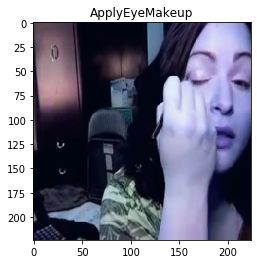

In [166]:
show_image(test_ds[0]['image'], class_names[test_ds[0]['label']])

prediction BandMarching
groud truth: BandMarching


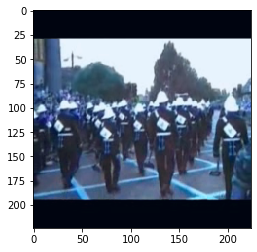

In [215]:
# We need to unsqueeze because the batch dimension is missing in the input.
# Usually we would iterate over the DataLoader, not the Dataset.
model.cuda()
model.eval()
idx = 200
inputs = test_ds[idx]['image'].unsqueeze(0).to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

print(f'prediction {class_names[preds]}')
print(f"groud truth: {class_names[test_ds[idx]['label']]}")


show_image(test_ds[idx]['image'])

In [173]:
inputs.unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

# References

[1] [DL tutorial for video classification](https://www.analyticsvidhya.com/blog/2019/09/step-by-step-deep-learning-tutorial-video-classification-python/)

[2] [Human action detection](https://courses.engr.illinois.edu/ie534/fa2019/AR.html)

[3] [3D-ResNets-PyTorch](https://github.com/kenshohara/3D-ResNets-PyTorch/blob/master/datasets/ucf101.py)

[4] [UCF101 torchvision](https://discuss.pytorch.org/t/ucf101-torchvision-dataset-to-dataloader-expected-object-of-scalar-type-float-but-got-scalar-type-short-for-sequence-element-1/64731)

[5] [3D-ResNets-PyTorch](https://github.com/kenshohara/3D-ResNets-PyTorch/blob/master/datasets/ucf101.py)

[6] [Iterable Datasets](https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd)

[7] [Handling exceptions in Dataloaders](https://discuss.pytorch.org/t/questions-about-dataloader-and-dataset/806/4)

[8] [Deep-learning-video-classification-python](https://www.analyticsvidhya.com/blog/2018/09/deep-learning-video-classification-python/)

[9] [Transfer-learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [ ]:
%debug